# Data Analysis on Movie Studios | Lucas Kimball & Eduardo Gonzalez | 9.15.23

## Business Problem


Welcome to the world of 'Just for Glory' Studios. We've ventured into the movie industry, driven not by financial gain but by our passion for creating exceptional films. Having achieved success in various other ventures, we embark on this cinematic journey with a singular goal – to produce top-tier, award-worthy movies that will stand the test of time.

Our mission is simple: we aspire to become the most decorated studio in the industry. To achieve this, we seek to unravel the secrets behind crafting award-winning films. We're keen to understand what makes a movie truly award-worthy, explore the genres that hold the key to success, and identify the factors that set exceptional movies apart from the rest.

## Data Sources

To embark on this exciting quest, we've armed ourselves with a wealth of data from various sources, including:

- Academy Award winners spanning from 1927 to 2015.
- Golden Globe Awards victors from 1944 to 2020.
- Valuable insights from Box Office Mojo.
- IMDb's extensive film database.
- Rotten Tomatoes' critical and audience scores.
- The Movie Database (TMDb) for comprehensive movie information.
- The Numbers, offering insights into movie financials.

Join us on this cinematic exploration as we dive into the data and uncover the ingredients that make movies shine on the silver screen. Let's begin our journey towards creating award-worthy masterpieces!


# Import packages and data

In [1]:
# Import necessary packages and suppress warnings

import pandas as pd
import sqlite3
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import gzip
import time
from fuzzywuzzy import fuzz
from fuzzywuzzy import process
warnings.filterwarnings('ignore')

## Importing the data

In [2]:
conn = sqlite3.connect('zippeddata/im.db')

movie_gross = pd.read_csv('zippeddata/bom.movie_gross.csv.gz')

with gzip.open('zippeddata/rt.movie_info.tsv.gz', 'rt', encoding='utf-8') as file:
    movie_info = pd.read_csv(file, delimiter='\t')

with gzip.open('zippeddata/rt.reviews.tsv.gz', 'rt') as file:
    reviews = pd.read_csv(file, delimiter='\t')

with gzip.open('zippeddata/tmdb.movies.csv.gz') as file:
    tmdb_movies = pd.read_csv(file)

with gzip.open('zippeddata/tn.movie_budgets.csv.gz') as file:
    movie_budgets = pd.read_csv(file)

golden_globe_awards = pd.read_csv('golden_globe_awards.csv')

academy_awards = pd.read_csv('academy_awards.csv')

In [3]:
#Create a list with the names of the different Datasets to make it easire to consult
df_list = ['conn','movie_gross','movie_info','reviews','tmdb_movies','movie_budgets', 'golden_globe_awards','academy_awards']

# Exploring the different Databases

## Exploring IMDb

In [4]:
pd.read_sql("""SELECT name, sql FROM sqlite_master WHERE type='table';""",conn)

,name,sql
0,movie_basics,"CREATE TABLE ""movie_basics"" (\n""movie_id"" TEXT..."
1,directors,"CREATE TABLE ""directors"" (\n""movie_id"" TEXT,\n..."
2,known_for,"CREATE TABLE ""known_for"" (\n""person_id"" TEXT,\..."
3,movie_akas,"CREATE TABLE ""movie_akas"" (\n""movie_id"" TEXT,\..."
4,movie_ratings,"CREATE TABLE ""movie_ratings"" (\n""movie_id"" TEX..."
5,persons,"CREATE TABLE ""persons"" (\n""person_id"" TEXT,\n ..."
6,principals,"CREATE TABLE ""principals"" (\n""movie_id"" TEXT,\..."
7,writers,"CREATE TABLE ""writers"" (\n""movie_id"" TEXT,\n ..."


In [5]:
pd.read_sql("""SELECT * FROM movie_basics LIMIT 2""",conn)

,movie_id,primary_title,original_title,start_year,runtime_minutes,genres
0,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama"
1,tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,2019,114.0,"Biography,Drama"


In [6]:
pd.read_sql("""SELECT * FROM directors LIMIT 2""",conn)

,movie_id,person_id
0,tt0285252,nm0899854
1,tt0462036,nm1940585


In [7]:
pd.read_sql("""SELECT * FROM known_for LIMIT 2""",conn)

,person_id,movie_id
0,nm0061671,tt0837562
1,nm0061671,tt2398241


In [8]:
pd.read_sql("""SELECT * FROM movie_akas LIMIT 2""",conn)

,movie_id,ordering,title,region,language,types,attributes,is_original_title
0,tt0369610,10,Джурасик свят,BG,bg,None,None,0.0
1,tt0369610,11,Jurashikku warudo,JP,None,imdbDisplay,None,0.0


In [9]:
pd.read_sql("""SELECT * FROM movie_ratings LIMIT 2""",conn)

,movie_id,averagerating,numvotes
0,tt10356526,8.3,31
1,tt10384606,8.9,559


In [10]:
pd.read_sql("""SELECT * FROM persons LIMIT 2""",conn)

,person_id,primary_name,birth_year,death_year,primary_profession
0,nm0061671,Mary Ellen Bauder,None,None,"miscellaneous,production_manager,producer"
1,nm0061865,Joseph Bauer,None,None,"composer,music_department,sound_department"


In [11]:
pd.read_sql("""SELECT * FROM principals LIMIT 2""",conn)

,movie_id,ordering,person_id,category,job,characters
0,tt0111414,1,nm0246005,actor,None,"[""The Man""]"
1,tt0111414,2,nm0398271,director,None,None


In [12]:
pd.read_sql("""SELECT * FROM writers LIMIT 2""",conn)

,movie_id,person_id
0,tt0285252,nm0899854
1,tt0438973,nm0175726


Based on this preliminary exploration, we can evaluate the content of every table within thew database, creating tin that way one solely chart that will have all we need for further exploration

We're going to evaluate what makes a movie win awards, so let's dive in what we need from each table.

movie_basics: We need the name of the movie, the runtime in minutes thast it playead and the genres, we decided to keep both the primary and the original name, to evaluate later which one is easire to pair the other dataframes with

directors: We're going to add the director of each movie.

known_for: We don't find any relevant information to add.

movie_akas: We don;t find any relevant information to add.

movie_ratings: We might want to see if there's any correlation in the awards and the rating and votes they get.

persons: We need the name of the directors of our movies, We also want to know if the person is still alive

principal: Having found above the relevant information about the directors, we don't need the information about them.

writers: We don't find any relevant information to add.

### Movie_ratings

We're evaluating if the amount of votes will be a necessary value to keep, we plot an histogram on a logaritmic scale.

This Column has a mean of 3523.66 a median of 49.0 and a standard deviation of 30294.02, is not worth to keep, is far from normally distributed


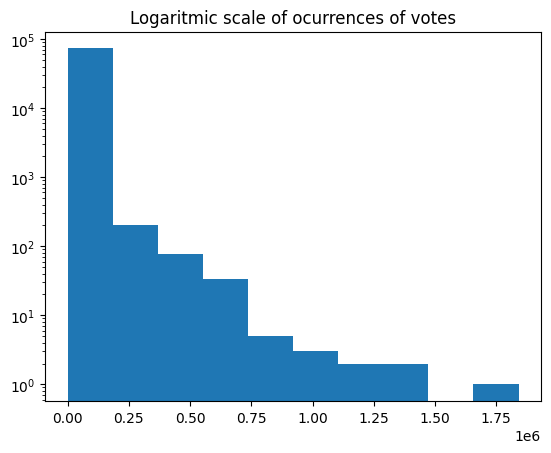

In [13]:
votes = pd.read_sql("""SELECT * FROM movie_ratings """,conn)['numvotes']
plt.hist(votes, log=True);
plt.title('Logaritmic scale of ocurrences of votes');
print(f"This Column has a mean of {round(votes.mean(),2)} a median of {votes.median()} and a \
standard deviation of {round(votes.std(),2)}, is not worth to keep, is far from normally distributed")

We had to do a logaritmic adjust to evaluate the distribution, because of the big ocurrence of outliers. We decided tro discard this.

### Average Rating

Evaluating the distribution.

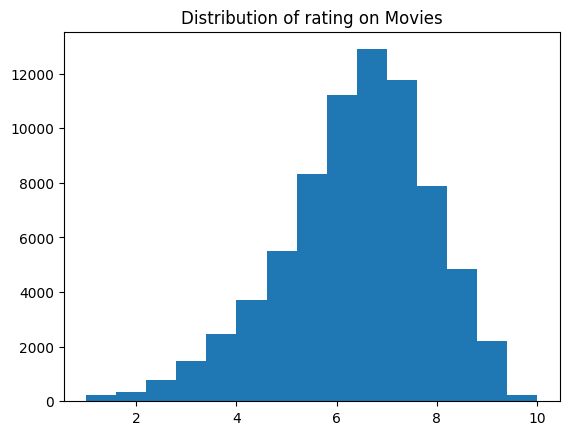

In [14]:
#Plotting the distribution of ratings
rating = pd.read_sql("""SELECT * FROM movie_ratings""",conn)['averagerating']
plt.hist(rating, bins=15);
plt.title('Distribution of rating on Movies');

We notice that the average rating has a distribution similar to a normal one, slightly skewed, we're going to keep it for further analysis.

### Creating the Query to extract the desired DataFrame

In [15]:
#Creating a Query for this database to Extract the Desired Data From it

imdb = pd.read_sql("""
SELECT primary_title, original_title, start_year, runtime_minutes, primary_name AS director_name, death_year, averagerating, genres
FROM movie_basics
LEFT JOIN directors USING(movie_id)
LEFT JOIN persons USING(person_id)
LEFT JOIN movie_ratings USING(movie_id)
GROUP BY movie_id
""",conn)

### Genres

As we notice above, the genres column has more than one value per movie, that'd make it hard to analyze going forward. We decided instead to created columns for the different genres and assign a binary value in case the movie falls into that specific genre.

In [16]:
#We make sure that every row has a value in the genre column.
imdb = imdb.drop_duplicates(subset=['primary_title'])
imdb['genres'].fillna('No Genre', inplace=True)
# Split the 'genres' column into a list of genres and then explode them into separate rows
imdb['genres'] = imdb['genres'].str.split(',')
imdb = imdb.explode('genres')
# Create binary indicators for each genre
for genre in imdb['genres'].dropna().unique():
    imdb[genre] = imdb['genres'].str.contains(genre).astype(int)
# Drop the original genres column
imdb.drop(columns=['genres'], inplace=True)

That made what we needed, but now we have as many rows per movie as genres they're in, we need to consolidate them

In [17]:
# Separate what are "genres column" from "non genres column"
non_genre_columns = ['primary_title', 'original_title','start_year','runtime_minutes','director_name','death_year','averagerating']
genre_columns = imdb.columns.difference(non_genre_columns)
# Group by 'primary_title' and sum the genre columns
genres_consolidated = imdb.groupby('primary_title', as_index=False)[genre_columns].sum()

#Merging all the columns together
imdb = pd.merge(imdb[non_genre_columns], genres_consolidated, on='primary_title')
#Elimintating duplicates based on primary_title
imdb = imdb.drop_duplicates(subset=['primary_title'])
imdb.reset_index(drop=True, inplace=True)

### Null values

Different methods were used to fill the null values in our database.

The most important to keep in mind is the averagerating, filled by the median of the values in the column.

In [18]:
#If we don't have the original_title, we'll just keep the primary_title.
imdb['original_title'].fillna(imdb['primary_title'], inplace=True)
#For runtime_minutes and death_year, we'll use 0 as a placeholder value
imdb['runtime_minutes'].fillna(0, inplace=True)
imdb['death_year'].fillna(0, inplace=True)
#For directors, we'll replace with 'Unknown'
imdb['director_name'].fillna('Unknown',inplace=True)
#For the averagerating we decided to fill the null values with the median.
imdb['averagerating'].fillna(imdb['averagerating'].median(),inplace=True)



### Exploring Resulting Data

In [19]:
imdb.head()

,primary_title,original_title,start_year,runtime_minutes,director_name,death_year,averagerating,Action,Adult,Adventure,...,No Genre,Reality-TV,Romance,Sci-Fi,Short,Sport,Talk-Show,Thriller,War,Western
0,Sunghursh,Sunghursh,2013,175.0,Harnam Singh Rawail,2004.0,7.0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,One Day Before the Rainy Season,Ashad Ka Ek Din,2019,114.0,Mani Kaul,2011.0,7.2,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,The Other Side of the Wind,The Other Side of the Wind,2018,122.0,Orson Welles,1985.0,6.9,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Sabse Bada Sukh,Sabse Bada Sukh,2018,0.0,Hrishikesh Mukherjee,2006.0,6.1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,The Wandering Soap Opera,La Telenovela Errante,2017,80.0,Raoul Ruiz,2011.0,6.5,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [20]:
imdb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 136071 entries, 0 to 136070
Data columns (total 35 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   primary_title    136071 non-null  object 
 1   original_title   136071 non-null  object 
 2   start_year       136071 non-null  int64  
 3   runtime_minutes  136071 non-null  float64
 4   director_name    136071 non-null  object 
 5   death_year       136071 non-null  float64
 6   averagerating    136071 non-null  float64
 7   Action           136071 non-null  int32  
 8   Adult            136071 non-null  int32  
 9   Adventure        136071 non-null  int32  
 10  Animation        136071 non-null  int32  
 11  Biography        136071 non-null  int32  
 12  Comedy           136071 non-null  int32  
 13  Crime            136071 non-null  int32  
 14  Documentary      136071 non-null  int32  
 15  Drama            136071 non-null  int32  
 16  Family           136071 non-null  int3

In [21]:
imdb.describe()

,start_year,runtime_minutes,death_year,averagerating,Action,Adult,Adventure,Animation,Biography,Comedy,...,No Genre,Reality-TV,Romance,Sci-Fi,Short,Sport,Talk-Show,Thriller,War,Western
count,136071.000000,136071.000000,136071.000000,136071.000000,136071.000000,136071.000000,136071.000000,136071.000000,136071.000000,136071.000000,...,136071.000000,136071.000000,136071.000000,136071.000000,136071.000000,136071.000000,136071.000000,136071.000000,136071.000000,136071.000000
mean,2014.561413,67.518325,12.702317,6.418684,0.070037,0.000184,0.044859,0.019754,0.061086,0.176481,...,0.035944,0.000698,0.063489,0.022613,0.000066,0.015382,0.000367,0.076754,0.009664,0.003160
std,2.732568,156.417561,159.460165,1.055786,0.255210,0.013553,0.206995,0.139156,0.239488,0.381231,...,0.186152,0.026414,0.243841,0.148667,0.008133,0.123066,0.019166,0.266202,0.097830,0.056126
min,2010.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2012.000000,37.000000,0.000000,6.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2015.000000,79.000000,0.000000,6.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,2017.000000,95.000000,0.000000,6.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,2027.000000,51420.000000,2019.000000,10.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### Runtime

We can advert that there are some outliers that won't allow us to visualize the complete data distribution.

We created a threshold to be able to visualize the data properly without the big outliers.

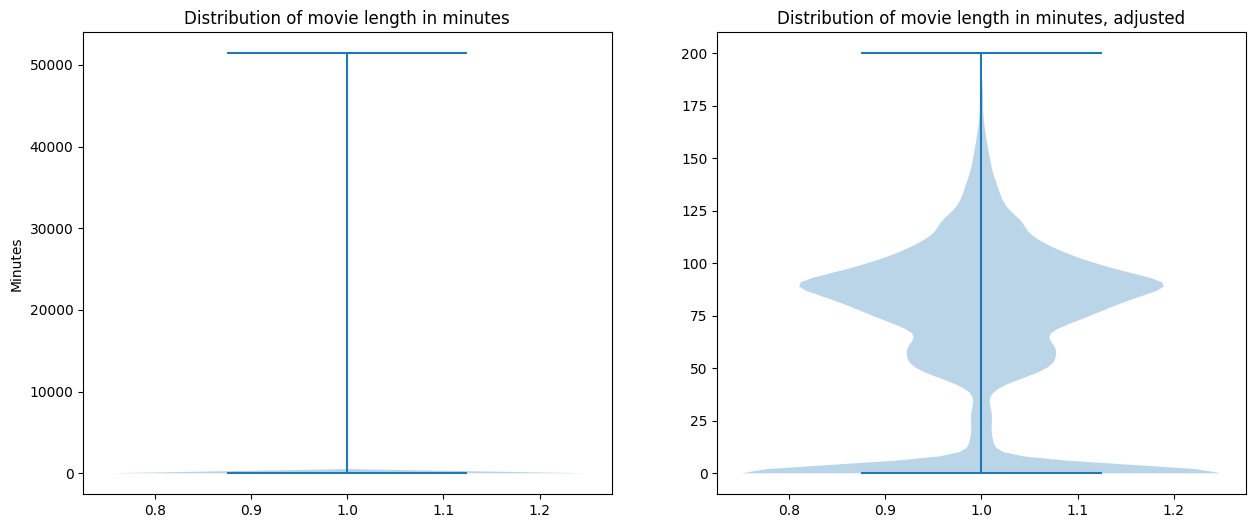

In [22]:
fig, (ax1,ax2) = plt.subplots(ncols=2, figsize=(15,6))
ax1.violinplot(imdb['runtime_minutes'])
ax1.set_title('Distribution of movie length in minutes')
ax1.set_ylabel('Minutes');

threshold = 200  # Adjust this threshold based on your data
runtime_with_threshold = [x for x in imdb['runtime_minutes'] if x <= threshold]
ax2.violinplot(runtime_with_threshold)
ax2.set_title('Distribution of movie length in minutes, adjusted');

### What genres the movies are?

Now we continue to analyze the dataset by vieweing the number of genres ocurrences in the dataset.

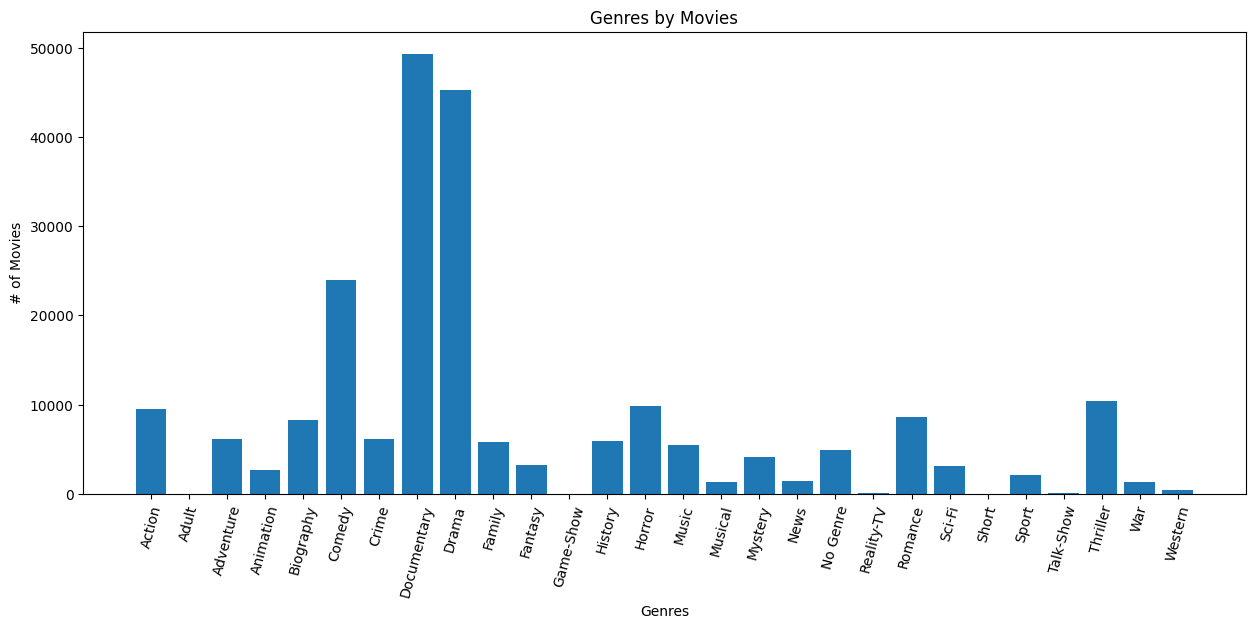

In [23]:
category_columns = ['Action', 'Adult',
       'Adventure', 'Animation', 'Biography', 'Comedy', 'Crime', 'Documentary',
       'Drama', 'Family', 'Fantasy', 'Game-Show', 'History', 'Horror', 'Music',
       'Musical', 'Mystery', 'News', 'No Genre', 'Reality-TV', 'Romance',
       'Sci-Fi', 'Short', 'Sport', 'Talk-Show', 'Thriller', 'War', 'Western']
columns_sums = imdb[category_columns].sum()
fig, ax = plt.subplots(figsize=(15,6))
plt.bar(columns_sums.index, columns_sums)
plt.xticks(rotation=75)
plt.title('Genres by Movies')
plt.xlabel('Genres')
plt.ylabel('# of Movies');
        

As we can see there's a big number of movies that falls in either documentary or drama. We need to keep in mind that some movies might fall into more than once category.

## Movie_gross
Since we're going to work only with US based awards, we're going to focus on domestic gross rather than foreign_gross.

We drop all the columns and rows that we don't need or are irrelevant for our analysis.

In [24]:
#Dropping unnecessary columns and rows
movie_gross.drop(columns=['studio','year','foreign_gross'],inplace=True)
movie_gross.dropna(axis=0, inplace=True)

In [25]:
movie_gross.describe()

,domestic_gross
count,3.359000e+03
mean,2.874585e+07
std,6.698250e+07
min,1.000000e+02
25%,1.200000e+05
50%,1.400000e+06
75%,2.790000e+07
max,9.367000e+08


## TMDB movies

In [26]:
tmdb_movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26517 entries, 0 to 26516
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Unnamed: 0         26517 non-null  int64  
 1   genre_ids          26517 non-null  object 
 2   id                 26517 non-null  int64  
 3   original_language  26517 non-null  object 
 4   original_title     26517 non-null  object 
 5   popularity         26517 non-null  float64
 6   release_date       26517 non-null  object 
 7   title              26517 non-null  object 
 8   vote_average       26517 non-null  float64
 9   vote_count         26517 non-null  int64  
dtypes: float64(2), int64(3), object(5)
memory usage: 2.0+ MB


In [27]:
tmdb_movies.head()

,Unnamed: 0,genre_ids,id,original_language,original_title,popularity,release_date,title,vote_average,vote_count
0,0,"[12, 14, 10751]",12444,en,Harry Potter and the Deathly Hallows: Part 1,33.533,2010-11-19,Harry Potter and the Deathly Hallows: Part 1,7.7,10788
1,1,"[14, 12, 16, 10751]",10191,en,How to Train Your Dragon,28.734,2010-03-26,How to Train Your Dragon,7.7,7610
2,2,"[12, 28, 878]",10138,en,Iron Man 2,28.515,2010-05-07,Iron Man 2,6.8,12368
3,3,"[16, 35, 10751]",862,en,Toy Story,28.005,1995-11-22,Toy Story,7.9,10174
4,4,"[28, 878, 12]",27205,en,Inception,27.920,2010-07-16,Inception,8.3,22186


In [28]:
#Keeping just the release year instead of the full date
tmdb_movies['release_year'] = tmdb_movies['release_date'].str[:4]
# drop unnecessary columns
tmdb_movies.drop(columns=['Unnamed: 0','original_language','popularity','vote_average','vote_count','release_date'],inplace=True)

### Genre unification
In this dataframe, the Genre column was identified just as ids. Founding online a dictionary with the corresponding Genre by map.
We're able to replace the numbers by the actual genre name.

After doing this, we found the same issue that on our IMBD database, having the genres combined instead of separated. Therefore, we create a new set of columns for the genres with binary values if the movie belongs to it

In [29]:
#Creating the genre dictionary
genre_mapping = {12: 'Adventure',
                 14: 'Fantasy',     
                 16: 'Animation',     
                 18: 'Drama',     
                 27: 'Horror',     
                 28: 'Action',     
                 35: 'Comedy',     
                 36: 'History',     
                 37: 'Western',     
                 53: 'Thriller',     
                 80: 'Crime',     
                 99: 'Documentary',     
                 9648: 'Mystery',     
                 10402: 'Music',     
                 10749: 'Romance',     
                 10751: 'Family',     
                 10752: 'War',     
                 10770: 'TV Movie',     
                 878: 'Science Fiction'} 

#Creating a function that will substitute the number with the corresponding genre.

def map_genre_ids(ids_str):
    ids = eval(ids_str)
    genres = [genre_mapping.get(id, 'Unknown') for id in ids]
    return ','.join(genres)
# Applying function to my data    
tmdb_movies['genres'] = tmdb_movies['genre_ids'].apply(map_genre_ids)
tmdb_movies.drop(columns='genre_ids',inplace=True)
#Everything that doesn't have a genre, substitute with 'Unknown'.
tmdb_movies.loc[tmdb_movies['genres'] == '', 'genres'] = 'Unknown'

In [30]:
#We make sure that every row has a value in the genre column.
tmdb_movies = tmdb_movies.drop_duplicates(subset=['id'])

# Split the 'genres' column into a list of genres and then explode them into separate rows
tmdb_movies['genres'] = tmdb_movies['genres'].str.split(',')

tmdb_movies = tmdb_movies.explode('genres')

# Create binary indicators for each genre
for genre in tmdb_movies['genres'].dropna().unique():
    tmdb_movies[genre] = tmdb_movies['genres'].str.contains(genre).astype(int)
# Drop the original genres column
tmdb_movies.drop(columns=['genres'], inplace=True)

# Separate what are "genres column" from "non genres column"
non_genre_columns = ['id','original_title','title','release_year']
genre_columns = tmdb_movies.columns.difference(non_genre_columns)
# Group by 'primary_title' and sum the genre columns
genres_consolidated = tmdb_movies.groupby('id', as_index=False)[genre_columns].sum()

#Merging all the columns together
tmdb_movies = pd.merge(tmdb_movies[non_genre_columns], genres_consolidated, on='id')
#Elimintating duplicates based on primary_title
tmdb_movies = tmdb_movies.drop_duplicates(subset=['id'])
tmdb_movies.reset_index(drop=True, inplace=True)

In [31]:
tmdb_movies['release_year'].value_counts().sort_index(ascending=False)

release_year
2020       1
2019      63
2018    2496
2017    2921
2016    2970
        ... 
1946       1
1939       1
1936       1
1933       1
1930       1
Name: count, Length: 66, dtype: int64

## Movie_budgets

In [32]:
movie_budgets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5782 entries, 0 to 5781
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   id                 5782 non-null   int64 
 1   release_date       5782 non-null   object
 2   movie              5782 non-null   object
 3   production_budget  5782 non-null   object
 4   domestic_gross     5782 non-null   object
 5   worldwide_gross    5782 non-null   object
dtypes: int64(1), object(5)
memory usage: 271.2+ KB


### Adjusting type

As we can see in the information about the movie_budgets data, we have the production_budget, the domestic_Gross and the worldwide_gross as object instead of integers.

We remove some of the characters that will create an issue by transforming the datatype, and afterwards we'll create two new columns to be able to visualize the domestic gross to budget ratio.

In [33]:
# Converting columns from string to numeric data types
columns_to_convert = ['worldwide_gross', 'production_budget', 'domestic_gross']
for col in columns_to_convert:
    movie_budgets[col] = pd.to_numeric(movie_budgets[col].str.replace('[$,]', '', regex=True), errors='coerce')
#creating a new column for worldwide_gross/production_budget measuring the amount made vs the amount spent
movie_budgets['worldwide_gross/production_budget'] = movie_budgets['worldwide_gross']/movie_budgets['production_budget']
#doing the same but for domestic gross
movie_budgets['domestic_gross/production_budget'] = movie_budgets['domestic_gross']/movie_budgets['production_budget']
#checking that it worked
movie_budgets.head(1)

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,worldwide_gross/production_budget,domestic_gross/production_budget
0,1,"Dec 18, 2009",Avatar,425000000,760507625,2776345279,6.532577,1.78943


# Awards Databases

Since we're trying to figure out which movies provide the most awards, we got access to a Database of the golge globe Awards from 1944 to 2020.

We'll try to explore the data to determine which factors make a movie worth of awards

## Golden Globes

### Exploring the data

In [34]:
#Import the Golden Globe Database
golden_globe_awards = pd.read_csv('golden_globe_awards.csv')

In [35]:
golden_globe_awards.head()

,year_film,year_award,ceremony,category,nominee,film,win
0,1943,1944,1,Best Performance by an Actress in a Supporting...,Katina Paxinou,For Whom The Bell Tolls,True
1,1943,1944,1,Best Performance by an Actor in a Supporting R...,Akim Tamiroff,For Whom The Bell Tolls,True
2,1943,1944,1,Best Director - Motion Picture,Henry King,The Song Of Bernadette,True
3,1943,1944,1,Picture,The Song Of Bernadette,NaN,True
4,1943,1944,1,Actress In A Leading Role,Jennifer Jones,The Song Of Bernadette,True


In [36]:
golden_globe_awards.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7991 entries, 0 to 7990
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   year_film   7991 non-null   int64 
 1   year_award  7991 non-null   int64 
 2   ceremony    7991 non-null   int64 
 3   category    7991 non-null   object
 4   nominee     7991 non-null   object
 5   film        6191 non-null   object
 6   win         7991 non-null   bool  
dtypes: bool(1), int64(3), object(3)
memory usage: 382.5+ KB


### Exploring and cleaning
We're going to use information about the winners, so we don't need to keep the people that was just nomineed.

In the exploration, we noticed that when the movie is the "nominee", the 'film' column gets a null value, so in those cases we'll copy the name from nominee into film.

We also remove unnecessary columns.

In [37]:
#Keeping only the winners, and dropping unnecessary columns
#When the nominee was the movie itself instead of an specific Crew member, the film cell was null.
# Having the Name of the film in the 'nominee' column. We replace accordingly
golden_globe_awards = golden_globe_awards.loc[golden_globe_awards['win'] == True]
golden_globe_awards.drop(columns=['year_award','ceremony','win'],inplace=True)
golden_globe_awards['film'] = golden_globe_awards['film'].fillna(golden_globe_awards['nominee'])

In [39]:
golden_globe_awards['category'].value_counts()

category
Best Performance by an Actress in a Supporting Role in any Motion Picture    79
Best Performance by an Actor in a Supporting Role in any Motion Picture      77
Best Director - Motion Picture                                               77
Best Performance by an Actor in a Motion Picture - Drama                     71
Best Performance by an Actress in a Motion Picture - Drama                   71
Best Performance by an Actor in a Motion Picture - Musical or Comedy         70
Best Motion Picture - Drama                                                  69
Best Original Score - Motion Picture                                         66
Best Screenplay - Motion Picture                                             63
Best Motion Picture - Musical or Comedy                                      63
New Star Of The Year - Actress                                               60
Henrietta Award (World Film Favorites)                                       59
Best Original Song - Motion Pic

### Categories
By evaluating the categories for the award, we decided to remove everything related to television shows (Since we're examining movies), and foreign awards, since our analysis is US based.

Also, we're consolidate the categories to make it easier to analyze.

In [38]:
#Removing awards not related to US movies
golden_globe_awards = golden_globe_awards[~golden_globe_awards['category'].str.contains('Television')]
golden_globe_awards = golden_globe_awards[~golden_globe_awards['category'].str.contains('Foreign')]

In [40]:
#Creating a category cleaning function
def cat_cleaner(char, cat):
    for i in char:
       golden_globe_awards.loc[golden_globe_awards['category'].str.contains(i,case=False), 'category'] = cat

#Creating a list that includes certain keywords that give us hints on the category type
soundtrack = ['song','music']
production = ['cinematography','screenplay','song','use of color']
best_actor = ['actor','performance']
directing = ['directing','director']
best_movie = ['picture']
best_actress = ['actress']

#Applying the category function

cat_cleaner(best_actor, 'Best Actor')
cat_cleaner(best_movie, 'Best Picture')
cat_cleaner(soundtrack, 'Soundtrack')
cat_cleaner(production, 'Production')
cat_cleaner(best_actress, 'Best Actress')
cat_cleaner(directing, 'Best Director')

#Every prize that won't fall in the categories mentioned above will be marked as 'others' 
golden_globe_awards.loc[((golden_globe_awards['category'] != 'Best Actor') & (golden_globe_awards['category'] != 'Best Picture') & 
                         (golden_globe_awards['category'] != 'Soundtrack') & (golden_globe_awards['category'] != 'Production') & 
                        (golden_globe_awards['category'] != 'Best Actress') & (golden_globe_awards['category'] != 'Best Director')),
                          'category'] = 'Others' 

Re-exploring the data

In [41]:
golden_globe_awards['category'].value_counts()

category
Best Actor      486
Best Picture    429
Others           97
Best Actress     67
Soundtrack       23
Production       14
Name: count, dtype: int64

In [42]:
golden_globe_awards.head()

,year_film,category,nominee,film
0,1943,Best Actor,Katina Paxinou,For Whom The Bell Tolls
1,1943,Best Actor,Akim Tamiroff,For Whom The Bell Tolls
2,1943,Best Picture,Henry King,The Song Of Bernadette
3,1943,Best Picture,The Song Of Bernadette,The Song Of Bernadette
4,1943,Best Actress,Jennifer Jones,The Song Of Bernadette


In [43]:
yearly = golden_globe_awards.groupby('year_film').count()

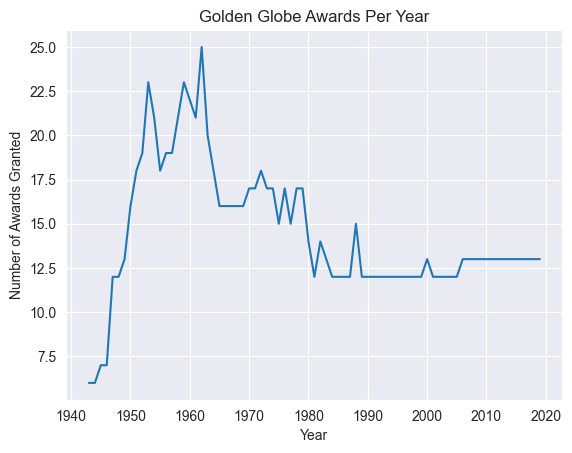

In [44]:
sns.set_style('darkgrid')
sns.lineplot(x = yearly.index, y = yearly['category'])
plt.title('Golden Globe Awards Per Year')
plt.xlabel('Year')
plt.ylabel('Number of Awards Granted');

We can see based on the above visualization, that the amount of awards per year has decreasedin comparison with their peak in the sixties, having 'plateau' aroun 1990, where the amount of awards has stayed the same.

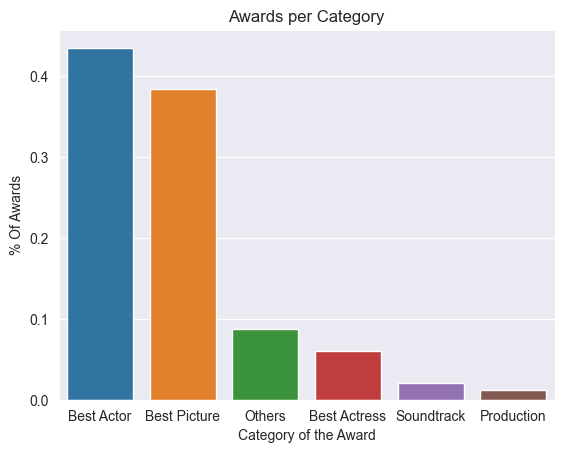

In [45]:
golden_globe_categories = golden_globe_awards['category'].value_counts(normalize=True)
sns.barplot(x = golden_globe_categories.index, y = golden_globe_categories)
plt.title('Awards per Category')
plt.xlabel('Award's Category')
plt.ylabel('% Of Awards');

In the above barplot, we can see how Best Actor and Best Picture are a big part of the complete set of awards given by the Golden globes over the years

### Creating Pivot tables Grouping nominees and films for the Golden Globes

For further analysis, we're creating tables grouped by films and nominees, allowing us to better explore the data.

In [46]:
#Creating a Table showing the golden globe awards grouped by film name.
golden_globe_by_film = golden_globe_awards.groupby('film').agg({'year_film': 'first', 'category': 'count'}).reset_index()
golden_globe_by_film.columns = ['Name', 'Year', 'Number Of Awards']
#Creating a Table showing the golden globe awards grouped by nominees.
golden_globe_by_nominee = golden_globe_awards.groupby('nominee').agg({'year_film': 'first', 'category': 'count'}).reset_index()
golden_globe_by_nominee.columns = ['Nominee', 'Year', 'Number Of Awards']

### Name matcher
With the new tables that we just created, we can merge them with the IMDb table, to get more insight into the movies that won awards.

Unfortunately, sometimes the names are not exactly the same in different tables, that's why we created a 'name_matcher' function, that allows us to create a similarity score between some names, and if that score is equal or above a threshold, cretaes a tuple with both names and the similarity score, to allow us later to merge them together based on it.


In [48]:
#Creating name_matcher function
def name_matcher(list1, list2, threshold):
    pairs = []
    for name1 in list1:
        for name2 in list2:
            similarity_score = fuzz.ratio(name1,name2)
            if similarity_score >= threshold:
                pairs.append((name1, name2, similarity_score))
    return pairs

Now that we have the function, we remove spaces and set everything lowercase to make it easiear to match

In [47]:
# Remove spaces from movie names and convert to lowercase for easier matching
golden_globe_by_film['Name_formatted'] = golden_globe_by_film['Name'].str.replace(' ', '').str.lower()
imdb['primary_title_cleaned'] = imdb['primary_title'].str.replace(' ', '').str.lower()

In [ ]:
#Assigning the variable 'pairs' to the name_matcher function, using the names that we cleaned in both golden globes and imdb.
# Setting up a threshold of 90
pairs = name_matcher(golden_globe_by_film['Name_formatted'],imdb['primary_title_cleaned'],90)

# Create a DataFrame from the list of matching pairs
pairs_GG_by_film = pd.DataFrame(pairs, columns=[ 'Golden_Globe_name','imdb_name', 'similarity_score'])

# Merge the two datasets using the paired Dataframe as a reference for the keys.
pairs_GG_by_film = pd.merge(imdb, pairs_GG_by_film, left_on='primary_title_cleaned', right_on='imdb_name', how='inner')
merged_data_GG_by_film = pd.merge(pairs_GG_by_film, golden_globe_by_film, left_on='Golden_Globe_name', right_on='Name_formatted', how='inner')
merged_data_GG_by_film.head()

During the merge, is possible that we see two movies that has the same, or very similar name, but being two actual different movies, in this case we're using the year as a reference. But since there's a chance that a movie get an award the year after it was released, we creates another column with the magnitude of difference between the year of the awards and the year it was released.

Everything above two years is discarded.

In [52]:
#creating a new column called year_difference, which will be used for cleaning mismatches that had high similarity scores
merged_data_GG_by_film['year_difference'] = abs(merged_data_GG_by_film['start_year'] - merged_data_GG_by_film['Year'])
merged_data_GG_by_film = merged_data_GG_by_film[merged_data_GG_by_film['year_difference'] < 2]

merged_data_GG_by_film.head()

,primary_title,original_title,start_year,runtime_minutes,director_name,death_year,averagerating,Action,Adult,Adventure,...,Western,primary_title_cleaned,Golden_Globe_name,imdb_name,similarity_score,Name,Year,Number Of Awards,Name_formatted,year_difference
0,Toy Story 3,Toy Story 3,2010,103.0,Lee Unkrich,0.0,8.3,0,0,1,...,0,toystory3,toystory3,toystory3,100,Toy Story 3,2010,1,toystory3,0
1,Lincoln,Lincoln,2012,150.0,Steven Spielberg,0.0,7.4,0,0,0,...,0,lincoln,lincoln,lincoln,100,Lincoln,2012,1,lincoln,0
2,Life of Pi,Life of Pi,2012,127.0,Ang Lee,0.0,7.9,0,0,1,...,0,lifeofpi,lifeofpi,lifeofpi,100,Life of Pi,2012,1,lifeofpi,0
3,Dallas Buyers Club,Dallas Buyers Club,2013,117.0,Jean-Marc Vallée,0.0,8.0,0,0,0,...,0,dallasbuyersclub,dallasbuyersclub,dallasbuyersclub,100,Dallas Buyers Club,2013,2,dallasbuyersclub,0
6,How to Train Your Dragon 2,How to Train Your Dragon 2,2014,102.0,Dean DeBlois,0.0,7.8,1,0,1,...,0,howtotrainyourdragon2,howtotrainyourdragon2,howtotrainyourdragon2,100,How to Train Your Dragon 2,2014,1,howtotrainyourdragon2,0


We prepared to do the same with the data of the golden globes by nominees. This is because we might find ocurrences in which the name of the movie was actually in the nominee column.

To make sure that we're keeping all of them, we're merging the imdb database with both grouped tables (by film and by nominee), afterwards we'll concatenate them by rows, and eliminate duplicates, so we can have only one ocurrence per movie.

In [53]:

# Remove characters and convert to lowercase using chaining methods
golden_globe_by_nominee['Nominee_formatted'] = (
    golden_globe_by_nominee['Nominee']
    .str.replace(',', '')
    .str.replace(' ', '')
    .str.replace('"', '')
    .str.lower()
)

# Remove characters and convert to lowercase using chaining methods
imdb['primary_title_cleaned'] = (
    imdb['primary_title']
    .str.replace(',', '')
    .str.replace(' ', '')
    .str.replace('"', '')
    .str.lower()
)

,Nominee,Year,Number Of Awards,Nominee_formatted
0,Topol,1964,2,topol
1,"""A Love That Will Never Grow Old"", Gustavo San...",2005,1,alovethatwillnevergrowoldgustavosantaolallaber...
2,"""City of Stars"", Justin Hurwitz, Benj Pasek, J...",2016,1,cityofstarsjustinhurwitzbenjpasekjustinpaul
3,"""Glory"", Common, John Legend",2014,1,glorycommonjohnlegend
4,"""Guaranteed"", Eddie Vedder",2007,1,guaranteededdievedder


In [ ]:
#Applying the name_matcher function to the new datasets we want to merge.
pairs2 = name_matcher(golden_globe_by_nominee['Nominee_formatted'], imdb['primary_title_cleaned'], 90)

# Create a DataFrame from the list of matching pairs
pairs_GG_by_nominee = pd.DataFrame(pairs2, columns=[ 'Golden_Globe_nominee','imdb_name', 'similarity_score'])


# Merge the two datasets using the paired Dataframe as a reference for the keys.
pairs_GG_by_nominee = pd.merge(imdb, pairs_GG_by_nominee, left_on='primary_title_cleaned', right_on='imdb_name', how='inner')
merged_data_GG_by_nominee = pd.merge(pairs_GG_by_nominee, golden_globe_by_nominee, left_on='Golden_Globe_nominee', right_on='Nominee_formatted', how='inner')

#creating a new column called year_difference, which will be used for cleaning mismatches that had high similarity scores
merged_data_GG_by_nominee['year_difference'] = abs(merged_data_GG_by_nominee['start_year'] - merged_data_GG_by_nominee['Year'])
merged_data_GG_by_nominee = merged_data_GG_by_nominee[merged_data_GG_by_nominee['year_difference'] < 2]

merged_data_GG_by_nominee.head()

In [58]:
# Concatenate the dfs
Golden_Globes_Winners = pd.concat([merged_data_GG_by_film, merged_data_GG_by_nominee], axis=0)
#reset the index
Golden_Globes_Winners.reset_index(drop=True, inplace=True)

Golden_Globes_Winners.head()

,primary_title,original_title,start_year,runtime_minutes,director_name,death_year,averagerating,Action,Adult,Adventure,...,imdb_name,similarity_score,Name,Year,Number Of Awards,Name_formatted,year_difference,Golden_Globe_nominee,Nominee,Nominee_formatted
0,Toy Story 3,Toy Story 3,2010,103.0,Lee Unkrich,0.0,8.3,0,0,1,...,toystory3,100,Toy Story 3,2010,1,toystory3,0,NaN,NaN,NaN
1,Lincoln,Lincoln,2012,150.0,Steven Spielberg,0.0,7.4,0,0,0,...,lincoln,100,Lincoln,2012,1,lincoln,0,NaN,NaN,NaN
2,Life of Pi,Life of Pi,2012,127.0,Ang Lee,0.0,7.9,0,0,1,...,lifeofpi,100,Life of Pi,2012,1,lifeofpi,0,NaN,NaN,NaN
3,Dallas Buyers Club,Dallas Buyers Club,2013,117.0,Jean-Marc Vallée,0.0,8.0,0,0,0,...,dallasbuyersclub,100,Dallas Buyers Club,2013,2,dallasbuyersclub,0,NaN,NaN,NaN
4,How to Train Your Dragon 2,How to Train Your Dragon 2,2014,102.0,Dean DeBlois,0.0,7.8,1,0,1,...,howtotrainyourdragon2,100,How to Train Your Dragon 2,2014,1,howtotrainyourdragon2,0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80,Moonlight,Moonlight,2016,111.0,Barry Jenkins,0.0,7.4,0,0,0,...,moonlight,100,NaN,2016,1,NaN,0,moonlight,Moonlight,moonlight
81,"Three Billboards Outside Ebbing, Missouri","Three Billboards Outside Ebbing, Missouri",2017,115.0,Martin McDonagh,0.0,8.2,0,0,0,...,threebillboardsoutsideebbingmissouri,100,NaN,2017,1,NaN,0,threebillboardsoutsideebbingmissouri,"Three Billboards Outside Ebbing, Missouri",threebillboardsoutsideebbingmissouri
82,Green Book,Green Book,2018,130.0,Peter Farrelly,0.0,8.3,0,0,0,...,greenbook,100,NaN,2018,1,NaN,0,greenbook,Green Book,greenbook
83,Once Upon a Time ... in Hollywood,Once Upon a Time ... in Hollywood,2019,159.0,Quentin Tarantino,0.0,9.7,0,0,0,...,onceuponatime...inhollywood,100,NaN,2019,1,NaN,0,onceuponatime...inhollywood,Once Upon a Time...in Hollywood,onceuponatime...inhollywood


In [ ]:
Golden_Globes_Winners.info()

In [ ]:
#Eliminating unnecessary columns
Golden_Globes_Winners.drop(
    ['start_year',
     'primary_title_cleaned',
     'year_difference',
     'Nominee_formatted',
     'Name_formatted',
     'Name',
     'death_year',
     'original_title',
     'Golden_Globe_nominee',
     'imdb_name',
     'similarity_score',
     'Nominee',
     'Golden_Globe_name'
     ], axis=1, inplace=True)

Golden_Globes_Winners.drop_duplicates(inplace=True)
Golden_Globes_Winners.head()

## Academy Awards

In [62]:
academy_awards.head()

,Year,Ceremony,Award,Winner,Name,Film
0,1927/1928,1,Actor,NaN,Richard Barthelmess,The Noose
1,1927/1928,1,Actor,1.0,Emil Jannings,The Last Command
2,1927/1928,1,Actress,NaN,Louise Dresser,A Ship Comes In
3,1927/1928,1,Actress,1.0,Janet Gaynor,7th Heaven
4,1927/1928,1,Actress,NaN,Gloria Swanson,Sadie Thompson


In [63]:
academy_awards.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9964 entries, 0 to 9963
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Year      9964 non-null   object 
 1   Ceremony  9964 non-null   int64  
 2   Award     9964 non-null   object 
 3   Winner    2321 non-null   float64
 4   Name      9964 non-null   object 
 5   Film      9631 non-null   object 
dtypes: float64(1), int64(1), object(4)
memory usage: 467.2+ KB


In [64]:
academy_awards.describe(include='all')

,Year,Ceremony,Award,Winner,Name,Film
count,9964,9964.000000,9964,2321.0,9964,9631
unique,88,NaN,114,NaN,5747,6363
top,1942,NaN,Directing,NaN,Meryl Streep,Metro-Goldwyn-Mayer
freq,186,NaN,429,NaN,19,60
mean,NaN,45.471798,NaN,1.0,NaN,NaN
std,NaN,24.841392,NaN,0.0,NaN,NaN
min,NaN,1.000000,NaN,1.0,NaN,NaN
25%,NaN,23.000000,NaN,1.0,NaN,NaN
50%,NaN,44.000000,NaN,1.0,NaN,NaN
75%,NaN,68.000000,NaN,1.0,NaN,NaN


### Conditional switching

Some categories, as in the Golden Globes dataset, have the nominee and the film values swapped, we checked the entire database and we found that there are some specific awards and years that have the above-mentioned values swapped.

In [ ]:
#Creation conditions to swap the film and the name.
condition = ((academy_awards['Year'] == '1929/1930') & ((academy_awards['Award'] == 'Art Direction')\
         | (academy_awards['Award'] == 'Outstanding Production')\
         | (academy_awards['Award'] == 'Sound Recording') | (academy_awards['Award'] == 'Writing')))
#Swapping name and Film
temp = academy_awards.loc[condition, 'Film'].copy()
academy_awards.loc[condition, 'Film'] = academy_awards.loc[condition, 'Name']
academy_awards.loc[condition, 'Name'] = temp

#Creating a list of new awards to switch
awards_switched = [
    'Writing (Adaptation)','Writing (Screenplay, Adapted)','Writing (Screenplay Adapted from Other Material)',
    'Writing (Screenplay Based on Material Previously Produced or Published)',
    'Writing (Screenplay Based on Material from Another Medium)',
    'Writing (Screenplay, Based on Material from Another Medium)', 'Animated Feature Film',
    'Writing (Original Screenplay)','Cinematography','Directing','Sound Mixing','Writing (Adapted Screenplay)','Documentary (Feature)',
    'Sound Editing','Costume Design','Visual Effects','Documentary (Short Subject)','Film Editing','Foreign Language Film',
    'Makeup and Hairstyling','Music (Original Score)','Best Picture','Production Design','Short Film (Animated)',
    'Short Film (Live Action)','Writing (Screenplay)'
]
#Switching them
condition2 = (academy_awards['Award'].isin(awards_switched)) & (academy_awards['Year'] != '1927/1928')
temp = academy_awards.loc[condition2, 'Film'].copy()
academy_awards.loc[condition2, 'Film'] = academy_awards.loc[condition2, 'Name']
academy_awards.loc[condition2, 'Name'] = temp

In [67]:
academy_awards.head()

,Year,Ceremony,Award,Winner,Name,Film
0,1927/1928,1,Actor,NaN,Richard Barthelmess,The Noose
1,1927/1928,1,Actor,1.0,Emil Jannings,The Last Command
2,1927/1928,1,Actress,NaN,Louise Dresser,A Ship Comes In
3,1927/1928,1,Actress,1.0,Janet Gaynor,7th Heaven
4,1927/1928,1,Actress,NaN,Gloria Swanson,Sadie Thompson
...,...,...,...,...,...,...
9959,2015,88,Writing (Original Screenplay),1.0,Written by Josh Singer & Tom McCarthy,Spotlight
9960,2015,88,Writing (Original Screenplay),NaN,Screenplay by Jonathan Herman and Andrea Berlo...,Straight Outta Compton
9961,2015,88,Jean Hersholt Humanitarian Award,1.0,Debbie Reynolds,NaN
9962,2015,88,Honorary Award,1.0,Spike Lee,NaN


## CATEGORY FIXING

In [68]:
academy_awards.dropna(subset = 'Winner', axis=0, inplace = True)
academy_awards.drop(columns=['Winner','Ceremony'],inplace=True)
academy_awards['Year'] = academy_awards['Year'].str.slice(0,4)

In [69]:
academy_awards = academy_awards[~academy_awards['Award'].str.contains('Commendation')]
academy_awards = academy_awards[~academy_awards['Award'].str.contains('Honorary')]
academy_awards = academy_awards[~academy_awards['Award'].str.contains('Foreign')]
academy_awards = academy_awards[~academy_awards['Award'].str.contains('Humanitarian')]
def cat_cleaner(char, cat):
    for i in char:
       academy_awards.loc[academy_awards['Award'].str.contains(i,case=False), 'Award'] = cat

best_actress = ['actress']
best_actor = ['actor']
directing = ['directing','director']
music = ['music','sound']
writing  = ['writing']
production = ['dance','art','cinematography','special ach','effects','costume','makeup','production','editing']
overall_movie = ['documentary','short','picture','special award','feature film','Irving G. Thalberg Memorial Award','Gordon E. Sawyer Award']
cat_cleaner(overall_movie, 'Best Movie')
cat_cleaner(production, 'Production')
cat_cleaner(music, 'Soundtrack')
cat_cleaner(writing, 'Writing')
cat_cleaner(best_actor, 'Best Actor')
cat_cleaner(best_actress, 'Best Actress')
cat_cleaner(directing, 'Best Director')

In [70]:
academy_awards['Year'] = academy_awards['Year'].astype(int)

## Creating Pivot tables Grouping nominees and films for the Academy Awards

In [71]:
academy_by_film = academy_awards.groupby('Film').agg({'Year': 'first', 'Award': 'count'}).reset_index()
academy_by_film.columns = ['Film', 'Year', 'Number Of Awards']

academy_by_nominee = academy_awards.groupby('Name').agg({'Year': 'first', 'Award': 'count'}).reset_index()
academy_by_nominee.columns = ['Name', 'Year', 'Number Of Awards']


Text(0, 0.5, 'Number of Awards Granted')

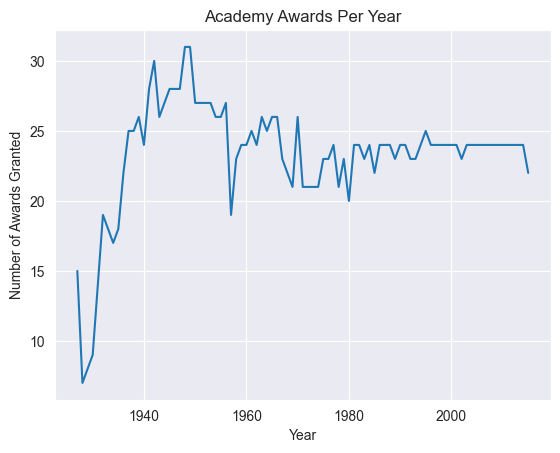

In [72]:
yearly_aa = academy_awards.groupby('Year').count()

sns.set_style('darkgrid')
sns.lineplot(x = yearly_aa.index, y = yearly_aa['Award'])
plt.title('Academy Awards Per Year')
plt.xlabel('Year')
plt.ylabel('Number of Awards Granted')
#plt.xticks([1925,1935,1945,1955,1965,1975,1985,1995,2005,2015])

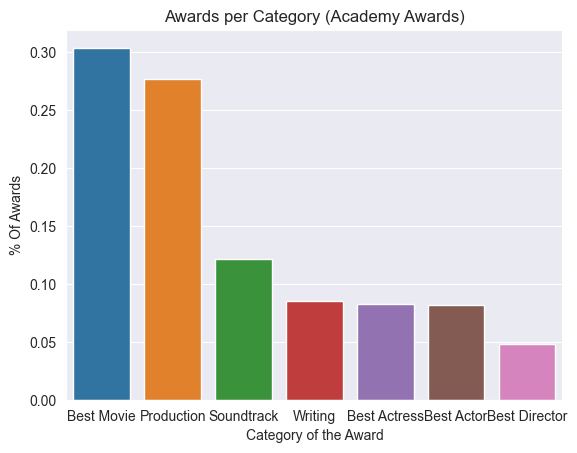

In [73]:
academy_categories = academy_awards['Award'].value_counts(normalize=True)
sns.barplot(x = academy_categories.index, y = academy_categories)
plt.title('Awards per Category (Academy Awards)')
plt.xlabel('Category of the Award')
plt.ylabel('% Of Awards');

In [74]:
# Remove spaces from movie names and convert to lowercase for easier matching

# Remove characters and convert to lowercase using chaining methods
academy_by_film['Film_formatted'] = (
    academy_by_film['Film']
    .str.replace(',', '')
    .str.replace(' ', '')
    .str.replace('"', '')
    .str.replace("'", '')
    .str.lower()
)

# Remove characters and convert to lowercase using chaining methods
imdb['primary_title_cleaned'] = (
    imdb['primary_title']
    .str.replace(',', '')
    .str.replace(' ', '')
    .str.replace('"', '')
    .str.replace("'", '')
    .str.lower()
)

#sanity check
academy_by_film


,Film,Year,Number Of Awards,Film_formatted
0,"""Charlie McCarthy""",1937,1,charliemccarthy
1,'Round Midnight,1986,1,roundmidnight
2,12 Years a Slave,2013,1,12yearsaslave
3,12 Years a Slave,2013,2,12yearsaslave
4,20 Feet from Stardom,2013,1,20feetfromstardom
...,...,...,...,...
1520,Zagreb Film,1961,1,zagrebfilm
1521,Zero Dark Thirty,2012,1,zerodarkthirty
1522,Zorba the Greek,1964,1,zorbathegreek
1523,the accountant,2001,1,theaccountant


In [75]:
pairs3 = name_matcher(academy_by_film['Film_formatted'],imdb['primary_title_cleaned'],90)

In [73]:
# # Start the timer
# start_time = time.time()


# # Initialize an empty list to store pairs
# pairs3 = []

# # Set a similarity score threshold (adjust as needed)
# threshold = 90

# # Perform fuzzy matching and create pairs
# for name1 in academy_by_film['Film_formatted']:
#     for name2 in imdb['primary_title_cleaned']:
#         similarity_score = fuzz.ratio(name1, name2)
#         if similarity_score >= threshold:
#             pairs3.append((name1, name2, similarity_score))
            


# # End the timer
# end_time = time.time()

# # Calculate the elapsed time
# elapsed_time = end_time - start_time

# print(f"Elapsed time: {elapsed_time} seconds")


In [76]:
# Create a DataFrame from the list of matching pairs
pairs_AA_by_film = pd.DataFrame(pairs3, columns=[ 'Academy_Film','imdb_name', 'similarity_score'])
pairs_AA_by_film

,Academy_Film,imdb_name,similarity_score
0,12yearsaslave,12yearsaslave,100
1,12yearsaslave,12yearsaslave,100
2,20feetfromstardom,20feetfromstardom,100
3,adoublelife,doublelife,95
4,agreektragedy,agreektragedy?,96
...,...,...,...
383,witness,iwitness,93
384,womeninlove,womaninlove,91
385,z,z,100
386,zerodarkthirty,zerodarkthirty,100


In [77]:
# Merge the two datasets based on the similarity score threshold
pairs_AA_by_film = pd.merge(imdb, pairs_AA_by_film, left_on='primary_title_cleaned', right_on='imdb_name', how='inner')
merged_data_AA_by_film = pd.merge(pairs_AA_by_film, academy_by_film, left_on='Academy_Film', right_on='Film_formatted', how='inner')

merged_data_AA_by_film

,primary_title,original_title,start_year,runtime_minutes,director_name,death_year,averagerating,Action,Adult,Adventure,...,War,Western,primary_title_cleaned,Academy_Film,imdb_name,similarity_score,Film,Year,Number Of Awards,Film_formatted
0,Toy Story 3,Toy Story 3,2010,103.0,Lee Unkrich,0.0,8.3,0,0,1,...,0,0,toystory3,toystory,toystory3,94,Toy Story,1995,1,toystory
1,Toy Story 4,Toy Story 4,2019,100.0,Josh Cooley,0.0,6.5,0,0,1,...,0,0,toystory4,toystory,toystory4,94,Toy Story,1995,1,toystory
2,Toy Story 3,Toy Story 3,2010,103.0,Lee Unkrich,0.0,8.3,0,0,1,...,0,0,toystory3,toystory3,toystory3,100,Toy Story 3,2010,1,toystory3
3,Lincoln,Lincoln,2012,150.0,Steven Spielberg,0.0,7.4,0,0,0,...,0,0,lincoln,lincoln,lincoln,100,Lincoln,2012,1,lincoln
4,Lincoln,Lincoln,2012,150.0,Steven Spielberg,0.0,7.4,0,0,0,...,0,0,lincoln,lincoln,lincoln,100,Lincoln,2012,1,lincoln
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
507,Spider-Man 4,Spider-Man 4,2020,0.0,Cheyanne Beatty,0.0,6.5,1,0,1,...,0,0,spider-man4,spider-man2,spider-man4,91,Spider-Man 2,2004,1,spider-man2
508,Ray,Ray,2018,111.0,Riingo Banerjee,0.0,6.5,0,0,0,...,0,0,ray,ray,ray,100,Ray,2004,1,ray
509,Ray,Ray,2018,111.0,Riingo Banerjee,0.0,6.5,0,0,0,...,0,0,ray,ray,ray,100,Ray,2004,1,ray
510,Ray,Ray,2018,111.0,Riingo Banerjee,0.0,6.5,0,0,0,...,0,0,ray,ray,ray,100,Ray,2004,1,ray


In [78]:
#creating a new column called year_difference, which will be used for cleaning mismatches that had high similarity scores
merged_data_AA_by_film['year_difference'] = abs(merged_data_AA_by_film['start_year'] - merged_data_AA_by_film['Year'])
merged_data_AA_by_film = merged_data_AA_by_film[merged_data_AA_by_film['year_difference'] < 2]

merged_data_AA_by_film.head()

,primary_title,original_title,start_year,runtime_minutes,director_name,death_year,averagerating,Action,Adult,Adventure,...,Western,primary_title_cleaned,Academy_Film,imdb_name,similarity_score,Film,Year,Number Of Awards,Film_formatted,year_difference
2,Toy Story 3,Toy Story 3,2010,103.0,Lee Unkrich,0.0,8.3,0,0,1,...,0,toystory3,toystory3,toystory3,100,Toy Story 3,2010,1,toystory3,0
3,Lincoln,Lincoln,2012,150.0,Steven Spielberg,0.0,7.4,0,0,0,...,0,lincoln,lincoln,lincoln,100,Lincoln,2012,1,lincoln,0
4,Lincoln,Lincoln,2012,150.0,Steven Spielberg,0.0,7.4,0,0,0,...,0,lincoln,lincoln,lincoln,100,Lincoln,2012,1,lincoln,0
5,Lincoln,Lincoln,2012,150.0,Steven Spielberg,0.0,7.4,0,0,0,...,0,lincoln,lincoln,lincoln,100,Lincoln,2012,1,lincoln,0
6,Lincoln,Lincoln,2012,150.0,Steven Spielberg,0.0,7.4,0,0,0,...,0,lincoln,lincoln,lincoln,100,Lincoln,2012,1,lincoln,0


In [79]:
academy_by_nominee.head()

,Name,Year,Number Of Awards
0,"""(I've Had) The Time Of My Life"" from Dirty Da...",1987,1
1,"""A Whole New World"" from Aladdin",1992,1
2,"""Al Otro Lado Del Río"" from The Motorcycle Dia...",2004,1
3,"""All The Way"" from The Joker Is Wild",1957,1
4,"""Arthur's Theme (Best That You Can Do)"" from A...",1981,1


In [80]:

# Remove characters and convert to lowercase using chaining methods
academy_by_nominee['Name_formatted'] = (
    academy_by_nominee['Name']
    .str.replace(',', '')
    .str.replace(' ', '')
    .str.replace('"', '')
    .str.replace('(', '')
    .str.replace(')', '')
    .str.lower()
)

# Remove characters and convert to lowercase using chaining methods
imdb['primary_title_cleaned'] = (
    imdb['primary_title']
    .str.replace(',', '')
    .str.replace(' ', '')
    .str.replace('"', '')
    .str.replace('(', '')
    .str.replace(')', '')
    .str.lower()
)

#sanity check
academy_by_nominee.head()

,Name,Year,Number Of Awards,Name_formatted
0,"""(I've Had) The Time Of My Life"" from Dirty Da...",1987,1,i'vehadthetimeofmylifefromdirtydancing
1,"""A Whole New World"" from Aladdin",1992,1,awholenewworldfromaladdin
2,"""Al Otro Lado Del Río"" from The Motorcycle Dia...",2004,1,alotroladodelríofromthemotorcyclediaries
3,"""All The Way"" from The Joker Is Wild",1957,1,allthewayfromthejokeriswild
4,"""Arthur's Theme (Best That You Can Do)"" from A...",1981,1,arthur'sthemebestthatyoucandofromarthur


In [81]:
pairs4 = name_matcher(academy_by_nominee['Name_formatted'],imdb['primary_title_cleaned'],90)

In [80]:
# # Start the timer
# start_time = time.time()


# # Initialize an empty list to store pairs
# pairs4 = []

# # Set a similarity score threshold (adjust as needed)
# threshold = 90

# # Perform fuzzy matching and create pairs
# for name1 in academy_by_nominee['Name_formatted']:
#     for name2 in imdb['primary_title_cleaned']:
#         similarity_score = fuzz.ratio(name1, name2)
#         if similarity_score >= threshold:
#             pairs4.append((name1, name2, similarity_score))
            


# # End the timer
# end_time = time.time()

# # Calculate the elapsed time
# elapsed_time = end_time - start_time

# print(f"Elapsed time: {elapsed_time} seconds")


In [82]:
# Create a DataFrame from the list of matching pairs
pairs_AA_by_nominee = pd.DataFrame(pairs4, columns=[ 'Academy_nominee','imdb_name', 'similarity_score'])
pairs_AA_by_nominee

,Academy_nominee,imdb_name,similarity_score
0,achristmascarol,achristmascarol,100
1,adoublelife,doublelife,95
2,amanandawoman,amanandawoman,100
3,amanforallseasons,amanforallseasons,100
4,aplaceinthesun,aplaceinthesun,100
...,...,...,...
161,witness,iwitness,93
162,witness,witness,100
163,witness,iwitness,93
164,wonderman,wonderwoman,90


In [83]:
# Merge the two datasets based on the similarity score threshold
pairs_AA_by_nominee = pd.merge(imdb, pairs_AA_by_nominee, left_on='primary_title_cleaned', right_on='imdb_name', how='inner')
merged_data_AA_by_nominee = pd.merge(pairs_AA_by_nominee, academy_by_nominee, left_on='Academy_nominee', right_on='Name_formatted', how='inner')

merged_data_AA_by_nominee

,primary_title,original_title,start_year,runtime_minutes,director_name,death_year,averagerating,Action,Adult,Adventure,...,War,Western,primary_title_cleaned,Academy_nominee,imdb_name,similarity_score,Name,Year,Number Of Awards,Name_formatted
0,Wonder Woman,Wonder Woman,2017,141.0,Patty Jenkins,0.0,7.5,1,0,1,...,0,0,wonderwoman,wonderman,wonderwoman,90,Wonder Man,1945,1,wonderman
1,The Wolfman,The Wolfman,2010,103.0,Joe Johnston,0.0,5.8,0,0,0,...,0,0,thewolfman,thewolfman,thewolfman,100,The Wolfman,2010,1,thewolfman
2,Hugo,Hugo,2011,126.0,Martin Scorsese,0.0,7.5,0,0,1,...,0,0,hugo,hugo,hugo,100,Hugo,2011,1,hugo
3,The Iron Lady,The Iron Lady,2011,105.0,Phyllida Lloyd,0.0,6.4,0,0,0,...,0,0,theironlady,theironlady,theironlady,100,The Iron Lady,2011,1,theironlady
4,CHICago,CHICago,2019,0.0,Kaleb Koho,0.0,6.5,0,0,1,...,0,0,chicago,chicago,chicago,100,Chicago,2002,2,chicago
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
169,"Gone, with the Wind","Gone, with the Wind",2018,92.0,Paul Bellini,0.0,6.5,0,0,0,...,0,0,gonewiththewind,gonewiththewind,gonewiththewind,100,Gone with the Wind,1939,3,gonewiththewind
170,How The West Was Once,How The West Was Once,2018,90.0,Dave Johnson,0.0,6.5,0,0,0,...,0,0,howthewestwasonce,howthewestwaswon,howthewestwasonce,91,How the West Was Won,1963,2,howthewestwaswon
171,From Her To Eternity,From Her To Eternity,2018,101.0,Scout Tafoya,0.0,6.5,0,0,0,...,0,0,fromhertoeternity,fromheretoeternity,fromhertoeternity,97,From Here to Eternity,1953,3,fromheretoeternity
172,Some Like It Hot 2,Some Like It Hot 2,2019,0.0,Xiaofei Song,0.0,6.5,0,0,0,...,0,0,somelikeithot2,somelikeithot,somelikeithot2,96,Some Like It Hot,1959,1,somelikeithot


In [84]:
#creating a new column called year_difference, which will be used for cleaning mismatches that had high similarity scores
merged_data_AA_by_nominee['year_difference'] = abs(merged_data_AA_by_nominee['start_year'] - merged_data_AA_by_nominee['Year'])
merged_data_AA_by_nominee = merged_data_AA_by_nominee[merged_data_AA_by_nominee['year_difference'] < 2]

merged_data_AA_by_nominee.head()

,primary_title,original_title,start_year,runtime_minutes,director_name,death_year,averagerating,Action,Adult,Adventure,...,Western,primary_title_cleaned,Academy_nominee,imdb_name,similarity_score,Name,Year,Number Of Awards,Name_formatted,year_difference
1,The Wolfman,The Wolfman,2010,103.0,Joe Johnston,0.0,5.8,0,0,0,...,0,thewolfman,thewolfman,thewolfman,100,The Wolfman,2010,1,thewolfman,0
2,Hugo,Hugo,2011,126.0,Martin Scorsese,0.0,7.5,0,0,1,...,0,hugo,hugo,hugo,100,Hugo,2011,1,hugo,0
3,The Iron Lady,The Iron Lady,2011,105.0,Phyllida Lloyd,0.0,6.4,0,0,0,...,0,theironlady,theironlady,theironlady,100,The Iron Lady,2011,1,theironlady,0
8,Alice in Wonderland,Alice in Wonderland,2010,108.0,Tim Burton,0.0,6.5,0,0,1,...,0,aliceinwonderland,aliceinwonderland,aliceinwonderland,100,Alice in Wonderland,2010,1,aliceinwonderland,0


In [85]:
# Concatenate the dfs
Academy_Awards_Winners = pd.concat([merged_data_AA_by_film, merged_data_AA_by_nominee], axis=0)
#reset the index
Academy_Awards_Winners.reset_index(drop=True, inplace=True)

Academy_Awards_Winners.head()

,primary_title,original_title,start_year,runtime_minutes,director_name,death_year,averagerating,Action,Adult,Adventure,...,imdb_name,similarity_score,Film,Year,Number Of Awards,Film_formatted,year_difference,Academy_nominee,Name,Name_formatted
0,Toy Story 3,Toy Story 3,2010,103.0,Lee Unkrich,0.0,8.3,0,0,1,...,toystory3,100,Toy Story 3,2010,1,toystory3,0,NaN,NaN,NaN
1,Lincoln,Lincoln,2012,150.0,Steven Spielberg,0.0,7.4,0,0,0,...,lincoln,100,Lincoln,2012,1,lincoln,0,NaN,NaN,NaN
2,Lincoln,Lincoln,2012,150.0,Steven Spielberg,0.0,7.4,0,0,0,...,lincoln,100,Lincoln,2012,1,lincoln,0,NaN,NaN,NaN
3,Lincoln,Lincoln,2012,150.0,Steven Spielberg,0.0,7.4,0,0,0,...,lincoln,100,Lincoln,2012,1,lincoln,0,NaN,NaN,NaN
4,Lincoln,Lincoln,2012,150.0,Steven Spielberg,0.0,7.4,0,0,0,...,lincoln,100,Lincoln,2012,1,lincoln,0,NaN,NaN,NaN


In [86]:
Academy_Awards_Winners.drop(
    ['start_year',
     'primary_title_cleaned',
     'year_difference',
     'Name_formatted',
     'Name',
     'death_year',
     'original_title',
     'Academy_nominee',
     'imdb_name',
     'similarity_score',
     'Academy_Film',
     'Film',
     'Film_formatted',
     ], axis=1, inplace=True)

In [87]:
Academy_Awards_Winners.drop_duplicates(inplace=True)
Academy_Awards_Winners

,primary_title,runtime_minutes,director_name,averagerating,Action,Adult,Adventure,Animation,Biography,Comedy,...,Romance,Sci-Fi,Short,Sport,Talk-Show,Thriller,War,Western,Year,Number Of Awards
0,Toy Story 3,103.0,Lee Unkrich,8.3,0,0,1,1,0,1,...,0,0,0,0,0,0,0,0,2010,1
1,Lincoln,150.0,Steven Spielberg,7.4,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,2012,1
5,Life of Pi,127.0,Ang Lee,7.9,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,2012,4
6,Ex Machina,108.0,Alex Garland,7.7,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,2015,1
7,Dallas Buyers Club,117.0,Jean-Marc Vallée,8.0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,2013,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74,Paper Man,110.0,Jason Heinrich,7.2,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,2012,1
75,Citizenfour,114.0,Laura Poitras,8.1,0,0,0,0,1,0,...,0,0,0,0,0,1,0,0,2014,1
76,Feast,0.0,Nathan Waters,7.8,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2014,1
77,The Wolfman,103.0,Joe Johnston,5.8,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2010,1


## Visualizing Golden Globe Award Winners

Text(0, 0.5, '# of Movies')

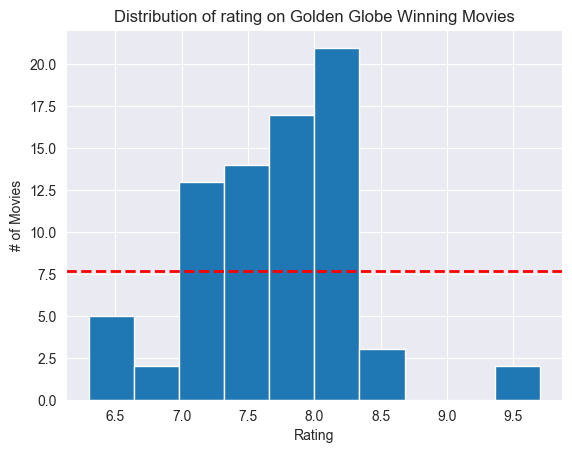

In [88]:
#histogram looking at the distribution of ratings for golden globe winning movies
rating = Golden_Globes_Winners['averagerating']
plt.hist(rating, bins=10);
plt.title('Distribution of rating on Golden Globe Winning Movies');
plt.axhline((Golden_Globes_Winners['averagerating'].mean()), color='red', linestyle='dashed', linewidth=2, label='Mean')
plt.xlabel('Rating')
plt.ylabel('# of Movies')

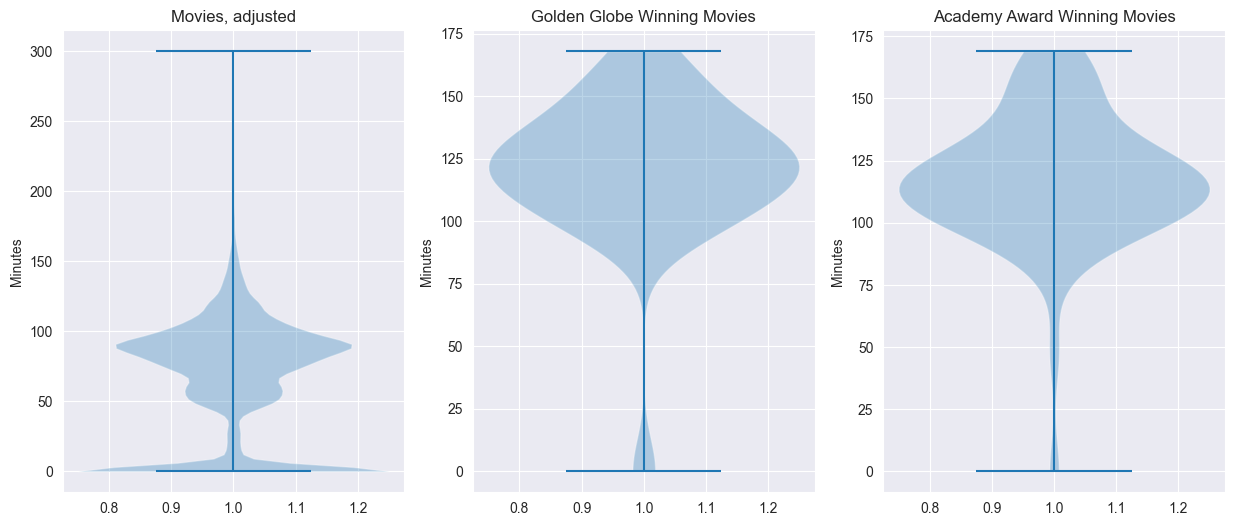

In [89]:
#violin plot of run times for all imdb movies v. academy award winning movies v. golden globe winning movies

fig, (ax1,ax2,ax3) = plt.subplots(ncols=3, figsize=(15,6))
ax2.violinplot(Golden_Globes_Winners['runtime_minutes'])
ax2.set_title('Golden Globe Winning Movies')
ax2.set_ylabel('Minutes');


# Threshold adjusted due to outlier runtimes
threshold = 300  
runtime_with_threshold = [x for x in imdb['runtime_minutes'] if x <= threshold]
ax1.violinplot(runtime_with_threshold)
ax1.set_title('Movies, adjusted');
ax1.set_ylabel('Minutes');

ax3.violinplot(Academy_Awards_Winners['runtime_minutes'])
ax3.set_title('Academy Award Winning Movies')
ax3.set_ylabel('Minutes');

## Visualizing Academy Award Winners

Text(0, 0.5, '# of Movies')

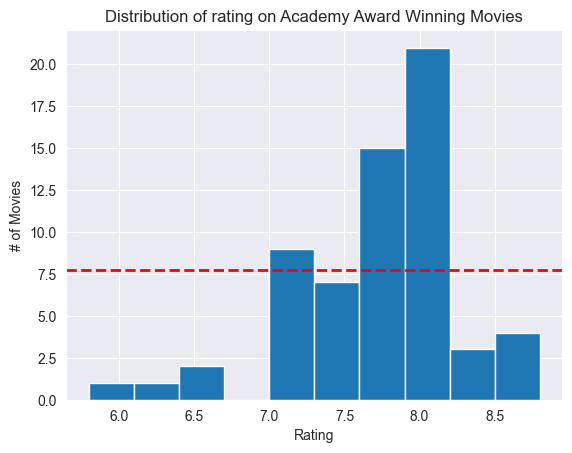

In [90]:
#histogram looking at the distribution of ratings for academy award winning movies
rating = Academy_Awards_Winners['averagerating']
plt.hist(rating, bins=10);
plt.title('Distribution of rating on Academy Award Winning Movies');
plt.axhline((Academy_Awards_Winners['averagerating'].mean()), color='red', linestyle='dashed', linewidth=2, label='Mean')
plt.xlabel('Rating')
plt.ylabel('# of Movies')

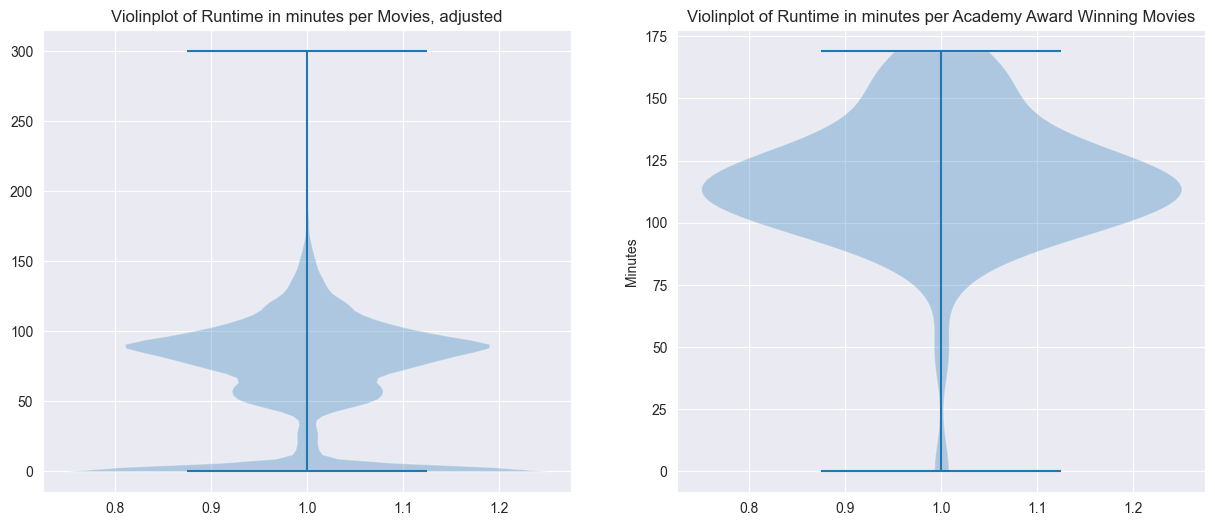

In [91]:
#violin plot of run times for all imdb movies v. academy award winning movies
fig, (ax1,ax2) = plt.subplots(ncols=2, figsize=(15,6))
ax2.violinplot(Academy_Awards_Winners['runtime_minutes'])
ax2.set_title('Violinplot of Runtime in minutes per Academy Award Winning Movies')
ax2.set_ylabel('Minutes');

threshold = 300  # Adjust this threshold based on your data
runtime_with_threshold = [x for x in imdb['runtime_minutes'] if x <= threshold]
ax1.violinplot(runtime_with_threshold)
ax1.set_title('Violinplot of Runtime in minutes per Movies, adjusted');

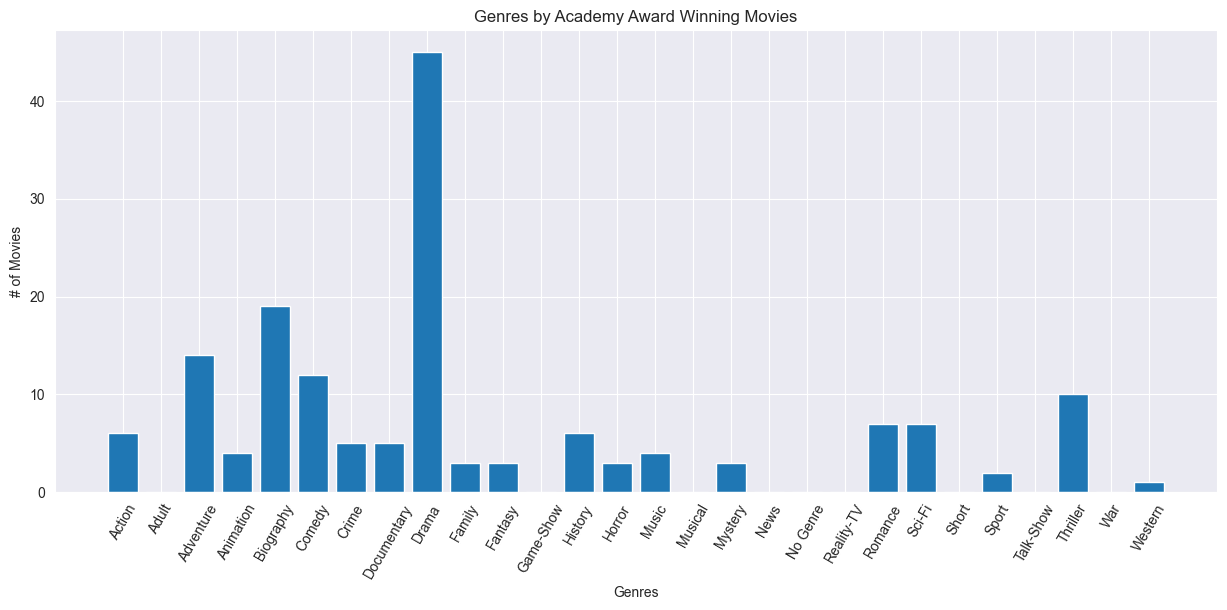

In [92]:
#Bar graph of the genres of Academy award winning movies
category_columns = ['Action', 'Adult',
       'Adventure', 'Animation', 'Biography', 'Comedy', 'Crime', 'Documentary',
       'Drama', 'Family', 'Fantasy', 'Game-Show', 'History', 'Horror', 'Music',
       'Musical', 'Mystery', 'News', 'No Genre', 'Reality-TV', 'Romance',
       'Sci-Fi', 'Short', 'Sport', 'Talk-Show', 'Thriller', 'War', 'Western']
columns_sums = Academy_Awards_Winners[category_columns].sum()
fig, ax = plt.subplots(figsize=(15,6))
plt.bar(columns_sums.index, columns_sums)
plt.xticks(rotation=60)
plt.title('Genres by Academy Award Winning Movies')
plt.xlabel('Genres')
plt.ylabel('# of Movies');
        

## Merging Golden Globe Awards with movie budgets

In [93]:
movie_budgets

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,worldwide_gross/production_budget,domestic_gross/production_budget
0,1,"Dec 18, 2009",Avatar,425000000,760507625,2776345279,6.532577,1.789430
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,410600000,241063875,1045663875,2.546673,0.587101
2,3,"Jun 7, 2019",Dark Phoenix,350000000,42762350,149762350,0.427892,0.122178
3,4,"May 1, 2015",Avengers: Age of Ultron,330600000,459005868,1403013963,4.243841,1.388403
4,5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,317000000,620181382,1316721747,4.153696,1.956408
...,...,...,...,...,...,...,...,...
5777,78,"Dec 31, 2018",Red 11,7000,0,0,0.000000,0.000000
5778,79,"Apr 2, 1999",Following,6000,48482,240495,40.082500,8.080333
5779,80,"Jul 13, 2005",Return to the Land of Wonders,5000,1338,1338,0.267600,0.267600
5780,81,"Sep 29, 2015",A Plague So Pleasant,1400,0,0,0.000000,0.000000


In [94]:
pairs5 = name_matcher(academy_by_film['Film'],movie_budgets['movie'],92)

In [95]:
# Create a DataFrame from the list of matching pairs
matching_data = pd.DataFrame(pairs5, columns=['gg_name', 'mb_name', 'similarity_score'])
# Merge the two datasets based on the similarity score threshold
golden_globes_movie_budgets = pd.merge(golden_globe_by_film, matching_data, left_on='Name', right_on='gg_name', how='inner')
golden_globes_movie_budgets = pd.merge(golden_globes_movie_budgets, movie_budgets, left_on='mb_name', right_on='movie', how='inner')


In [96]:
golden_globes_movie_budgets

,Name,Year,Number Of Awards,Name_formatted,gg_name,mb_name,similarity_score,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,worldwide_gross/production_budget,domestic_gross/production_budget
0,12 Years a Slave,2013,1,12yearsaslave,12 Years a Slave,12 Years a Slave,100,18,"Oct 18, 2013",12 Years a Slave,20000000,56671993,181025343,9.051267,2.833600
1,A Beautiful Mind,2001,4,abeautifulmind,A Beautiful Mind,A Beautiful Mind,100,12,"Dec 21, 2001",A Beautiful Mind,78000000,170708996,317668058,4.072667,2.188577
2,Adaptation,2002,2,adaptation,Adaptation,Adaptation,100,59,"Dec 6, 2002",Adaptation,18500000,22498520,32531759,1.758473,1.216136
3,Amadeus,1984,4,amadeus,Amadeus,Amadeus,100,81,"Sep 19, 1984",Amadeus,18000000,51973029,51973029,2.887390,2.887390
4,American Beauty,1999,3,americanbeauty,American Beauty,American Beauty,100,98,"Sep 15, 1999",American Beauty,15000000,130058047,356258047,23.750536,8.670536
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91,Unforgiven,1992,2,unforgiven,Unforgiven,Unforgiven,100,70,"Aug 7, 1992",Unforgiven,14400000,101157447,159157447,11.052600,7.024823
92,Vicky Cristina Barcelona,2008,1,vickycristinabarcelona,Vicky Cristina Barcelona,Vicky Cristina Barcelona,100,47,"Aug 15, 2008",Vicky Cristina Barcelona,16000000,23216709,104504817,6.531551,1.451044
93,Wall Street,1987,1,wallstreet,Wall Street,Wall Street,100,20,"Dec 11, 1987",Wall Street,16500000,43848100,43848100,2.657461,2.657461
94,West Side Story,1961,3,westsidestory,West Side Story,West Side Story,100,20,"Oct 18, 1961",West Side Story,6000000,43700000,43700000,7.283333,7.283333


In [97]:
golden_globes_movie_budgets.drop(columns=['mb_name','gg_name','similarity_score','id','release_date','movie'], inplace=True)

golden_globes_movie_budgets.drop_duplicates(keep='first',inplace=True)

In [98]:
golden_globes_movie_budgets

,Name,Year,Number Of Awards,Name_formatted,production_budget,domestic_gross,worldwide_gross,worldwide_gross/production_budget,domestic_gross/production_budget
0,12 Years a Slave,2013,1,12yearsaslave,20000000,56671993,181025343,9.051267,2.833600
1,A Beautiful Mind,2001,4,abeautifulmind,78000000,170708996,317668058,4.072667,2.188577
2,Adaptation,2002,2,adaptation,18500000,22498520,32531759,1.758473,1.216136
3,Amadeus,1984,4,amadeus,18000000,51973029,51973029,2.887390,2.887390
4,American Beauty,1999,3,americanbeauty,15000000,130058047,356258047,23.750536,8.670536
...,...,...,...,...,...,...,...,...,...
91,Unforgiven,1992,2,unforgiven,14400000,101157447,159157447,11.052600,7.024823
92,Vicky Cristina Barcelona,2008,1,vickycristinabarcelona,16000000,23216709,104504817,6.531551,1.451044
93,Wall Street,1987,1,wallstreet,16500000,43848100,43848100,2.657461,2.657461
94,West Side Story,1961,3,westsidestory,6000000,43700000,43700000,7.283333,7.283333


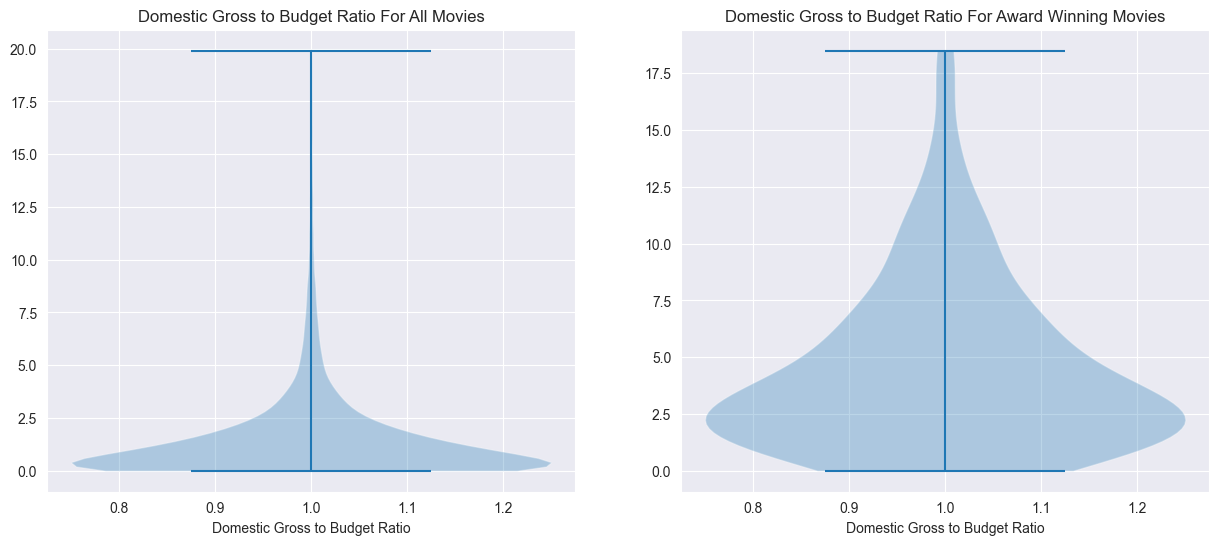

In [99]:
threshold = 20
domestic_budgets_with_threshold = [x for x in movie_budgets['domestic_gross/production_budget'] if x <= threshold]
award_winners_with_threshold = [x for x in golden_globes_movie_budgets['domestic_gross/production_budget'] if x <= threshold]

fig, (ax1,ax2) = plt.subplots(ncols=2, figsize=(15,6))
#ax1.bar(ggg.index, ggg)
#ax1.axhline(y=movie_budgets['domestic_gross/production_budget'].mean(), color='red', linestyle='--', label='Mean of all movie gross')
ax1.violinplot(domestic_budgets_with_threshold)
#ax1.set_yticks(range(20))
ax2.violinplot(award_winners_with_threshold)
#ax2.set_yticks(range(20))
ax1.set_title('Domestic Gross to Budget Ratio For All Movies')
ax2.set_title('Domestic Gross to Budget Ratio For Award Winning Movies')
ax1.set_xlabel('Domestic Gross to Budget Ratio')
ax2.set_xlabel('Domestic Gross to Budget Ratio');

In [100]:
imdb.columns

Index(['primary_title', 'original_title', 'start_year', 'runtime_minutes',
       'director_name', 'death_year', 'averagerating', 'Action', 'Adult',
       'Adventure', 'Animation', 'Biography', 'Comedy', 'Crime', 'Documentary',
       'Drama', 'Family', 'Fantasy', 'Game-Show', 'History', 'Horror', 'Music',
       'Musical', 'Mystery', 'News', 'No Genre', 'Reality-TV', 'Romance',
       'Sci-Fi', 'Short', 'Sport', 'Talk-Show', 'Thriller', 'War', 'Western',
       'primary_title_cleaned'],
      dtype='object')

In [101]:
genre_columns = ['Action', 'Adult',
       'Adventure', 'Animation', 'Biography', 'Comedy', 'Crime', 'Documentary',
       'Drama', 'Family', 'Fantasy', 'Game-Show', 'History', 'Horror', 'Music',
       'Musical', 'Mystery', 'News', 'No Genre', 'Reality-TV', 'Romance',
       'Sci-Fi', 'Short', 'Sport', 'Talk-Show', 'Thriller', 'War', 'Western']

In [102]:
directors = imdb.groupby('director_name').agg({'primary_title':'count', **{col: 'sum' for col in genre_columns}})

In [103]:
aa_directors = pd.merge(academy_by_nominee, directors, left_on = 'Name', right_on = 'director_name', how='inner')
gg_directors = pd.merge(golden_globe_by_nominee, directors, left_on = 'Nominee', right_on = 'director_name', how='inner')

In [104]:
aa_directors = aa_directors[['Name', 'Number Of Awards', 'primary_title','Adventure','Biography','Drama','Comedy']]
aa_directors.rename(columns={'primary_title':'Number of Movies Directed'}, inplace=True)
aa_directors.sort_values(by=['Number Of Awards','Drama'],ascending=False, inplace=True)
aa_directors = aa_directors.head(15)

In [105]:
gg_directors = gg_directors[['Nominee', 'Number Of Awards', 'primary_title','Adventure','Biography','Drama','Comedy']]
gg_directors.rename(columns={'primary_title':'Number of Movies Directed','Nominee':'Name'}, inplace=True)
gg_directors.sort_values(by=['Number Of Awards','Drama'],ascending=False, inplace=True)
gg_directors = gg_directors.head(15)

In [106]:
best_directors = pd.concat([aa_directors,gg_directors], axis=0)
best_directors.reset_index(drop=True)

,Name,Number Of Awards,Number of Movies Directed,Adventure,Biography,Drama,Comedy
0,John Williams,4,7,0,0,2,3
1,Clint Eastwood,3,6,0,5,6,0
2,Steven Spielberg,3,9,4,2,5,0
3,Oliver Stone,3,5,0,1,3,0
4,Anthony Powell,3,1,1,1,0,0
5,George Stevens,3,1,0,0,0,1
6,Nick Park,3,1,1,0,0,1
7,Ang Lee,2,4,1,1,4,0
8,Alejandro G. Iñárritu,2,3,1,1,2,1
9,Jodie Foster,2,2,0,0,2,0


In [107]:
dream_team = best_directors.groupby('Name').agg({'Number Of Awards':'sum', 'Number of Movies Directed':'first','Adventure':'first','Biography':'first','Drama':'first','Comedy':'first'})
dream_team.sort_values(['Number Of Awards','Drama'], ascending=False, inplace=True)

In [108]:
dt_rol = {'John Williams': 'Soundtrack','Clint Eastwood': 'Director','Oliver Stone': 'Director','Dustin Hoffman': 'Director','Steven Spielberg': 'Director', 'Robert Redford': 'Director','Francis Ford Coppola': 'Director','Ang Lee': 'Director','Tom Hanks': 'Actor','Martin Scorsese': 'Director','George Clooney': 'Actor','Quentin Tarantino': 'Director', 'Warren Beatty': 'Director', 'Anthony Powell': 'Dead','George Stevens': 'Director','Nick Park': 'Director', 'Woody Allen': 'Director','Damien Chazelle': 'Director', 'Alejandro G. Iñárritu': 'Director','Jodie Foster': 'Actress','Christoph Waltz': 'Actor','Denzel Washington': 'Actor','James L. Brooks':'Director'}

In [109]:
dream_team['Role'] = dream_team.index.map(dt_rol)
dream_team.loc[dream_team['Role'] == 'Director']

,Number Of Awards,Number of Movies Directed,Adventure,Biography,Drama,Comedy,Role
Name,,,,,,,
Clint Eastwood,7,6,0,5,6,0,Director
Oliver Stone,7,5,0,1,3,0,Director
Dustin Hoffman,6,1,0,0,1,1,Director
Steven Spielberg,5,9,4,2,5,0,Director
Robert Redford,5,3,0,0,2,0,Director
Francis Ford Coppola,5,2,0,0,1,1,Director
Ang Lee,4,4,1,1,4,0,Director
Martin Scorsese,3,10,2,3,4,0,Director
Quentin Tarantino,3,4,0,0,3,1,Director


In [110]:
academy_actors = academy_awards.loc[(academy_awards['Award'] == 'Best Actor') | (academy_awards['Award'] == 'Best Actress')]
academy_actors = academy_actors.groupby('Name').agg({'Year': 'first', 'Award': 'count'}).reset_index()
academy_actors.columns = ['Name', 'Year', 'Number Of Awards']
academy_actors.sort_values(by=['Number Of Awards'], ascending=False, inplace=True)

top_aa_actors = academy_actors.head(10)

In [111]:
golden_globe_actors = golden_globe_awards.loc[(golden_globe_awards['category'] == 'Best Actor') | (golden_globe_awards['category'] == 'Best Actress')]
golden_globe_actors = golden_globe_actors.groupby('nominee').agg({'year_film': 'first', 'category': 'count'}).reset_index()
golden_globe_actors.columns = ['nominee', 'Year', 'Number Of Awards']
golden_globe_actors.sort_values(by=['Number Of Awards'], ascending=False, inplace=True)

top_gg_actors = golden_globe_actors.head(10)
top_gg_actors.rename(columns={'nominee':'Name'},inplace=True)

In [112]:
top_actors = pd.concat([top_aa_actors,top_gg_actors], axis=0)
top_actors.reset_index(drop=True)

,Name,Year,Number Of Awards
0,Katharine Hepburn,1932,4
1,Jack Nicholson,1975,3
2,Meryl Streep,1979,3
3,Walter Brennan,1936,3
4,Ingrid Bergman,1944,3
5,Hilary Swank,1999,2
6,Maggie Smith,1969,2
7,Spencer Tracy,1937,2
8,Dianne Wiest,1986,2
9,Jason Robards,1976,2


In [113]:
top_actors = top_actors.groupby('Name')['Number Of Awards'].sum()

top_actors.sort_values(ascending=False)

Name
Meryl Streep         10
Jack Nicholson        9
Katharine Hepburn     4
Dustin Hoffman        4
Tom Hanks             4
Renée Zellweger       4
Peter O'Toole         4
Jane Fonda            4
Leonardo DiCaprio     3
Bette Midler          3
Jack Lemmon           3
Ingrid Bergman        3
Walter Brennan        3
Dianne Wiest          2
Maggie Smith          2
Jason Robards         2
Spencer Tracy         2
Hilary Swank          2
Name: Number Of Awards, dtype: int64